In [1]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# display images
# from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy


In [2]:
def conv_2_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [3]:
def conv_3_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [4]:
def conv_4_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [5]:
class VGG16(nn.Module):
    def __init__(self, base_dim, num_classes=10):
        super(VGG16, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim), #64
            conv_2_block(base_dim,2*base_dim), #128
            conv_3_block(2*base_dim,4*base_dim), #256
            conv_3_block(4*base_dim,8*base_dim), #512
            conv_3_block(8*base_dim,8*base_dim), #512
        )
        self.fc_layer = nn.Sequential(
            # CIFAR10은 크기가 32x32이므로
            nn.Linear(8*base_dim*1*1, 4096),
            # IMAGENET이면 224x224이므로
            # nn.Linear(8*base_dim*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_layer(x)
        return x

In [6]:
class VGG19(nn.Module):
    def __init__(self, base_dim, num_classes=10):
        super(VGG19, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim), #64
            conv_2_block(base_dim,2*base_dim), #128
            conv_4_block(2*base_dim,4*base_dim), #256
            conv_4_block(4*base_dim,8*base_dim), #512
            conv_4_block(8*base_dim,8*base_dim), #512
        )
        self.fc_layer = nn.Sequential(
            # CIFAR10은 크기가 32x32이므로
            nn.Linear(8*base_dim*1*1, 4096),
            # IMAGENET이면 224x224이므로
            # nn.Linear(8*base_dim*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_layer(x)
        return x

In [7]:
# device 설정
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

# VGG 클래스를 인스턴스화
model = VGG16(base_dim=64).to(device)

# 손실함수 및 최적화함수 설정
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Transform 정의
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10 TRAIN 데이터 정의
cifar10_train = datasets.CIFAR10(root="Data/", train=True, transform=transform, target_transform=None, download=True)

# CIFAR10 TEST 데이터 정의
cifar10_test = datasets.CIFAR10(root="Data/", train=False, transform=transform, target_transform=None, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [9]:
train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=100,
                                           shuffle=True, num_workers=6)

In [10]:
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=100,
                                           shuffle=True, num_workers=6)

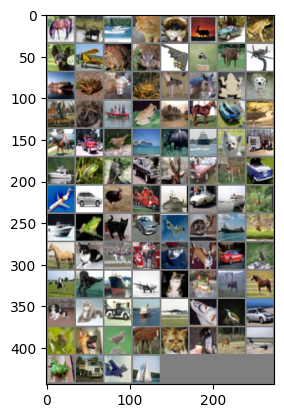

horse  deer  ship   cat   dog  deer   car  frog   dog plane


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
batch_size = 10

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [12]:
batch_size = 100
learning_rate = 0.0002
num_epoch = 100

In [13]:
from tqdm import trange

In [14]:
import torch
print(torch.__version__)
print("MPS available:", torch.backends.mps.is_available())

2.3.0
MPS available: True


In [15]:
print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
!python -c 'import platform;print(platform.platform())'

PyTorch version:2.3.0
MPS 장치를 지원하도록 build 되었는ㅌㅌㅌㅌ지: True
MPS 장치가 사용 가능한지: True
macOS-14.5-arm64-arm-64bit


In [16]:
from tqdm import trange
patience = 10  # 개선되지 않는 에포크 수
best_loss = float('inf')
trigger_times = 0

loss_arr = []
for i in trange(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y_ = label.to(device)

        optimizer.zero_grad()
        output = model(x)  # .forward()는 일반적으로 생략
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()
    print(loss)

    # 조기 종료 로직
    if i % 10 == 0:
        loss_arr.append(loss.cpu().detach().numpy())
        if loss < best_loss:
            best_loss = loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f'Early stopping! Epoch: {i}')
                break

  1%|▍                                        | 1/100 [01:18<2:09:05, 78.24s/it]

tensor(1.9188, device='mps:0', grad_fn=<NllLossBackward0>)


  2%|▊                                        | 2/100 [02:35<2:06:41, 77.56s/it]

tensor(1.6785, device='mps:0', grad_fn=<NllLossBackward0>)


  3%|█▏                                       | 3/100 [03:52<2:05:03, 77.35s/it]

tensor(1.4518, device='mps:0', grad_fn=<NllLossBackward0>)


  4%|█▋                                       | 4/100 [05:09<2:03:48, 77.38s/it]

tensor(1.4867, device='mps:0', grad_fn=<NllLossBackward0>)


  5%|██                                       | 5/100 [06:28<2:03:15, 77.84s/it]

tensor(1.0405, device='mps:0', grad_fn=<NllLossBackward0>)


  6%|██▍                                      | 6/100 [07:45<2:01:15, 77.40s/it]

tensor(0.8147, device='mps:0', grad_fn=<NllLossBackward0>)


  7%|██▊                                      | 7/100 [09:01<1:59:23, 77.02s/it]

tensor(0.9802, device='mps:0', grad_fn=<NllLossBackward0>)


  8%|███▎                                     | 8/100 [10:17<1:57:44, 76.79s/it]

tensor(0.8153, device='mps:0', grad_fn=<NllLossBackward0>)


  9%|███▋                                     | 9/100 [11:34<1:56:17, 76.67s/it]

tensor(0.7090, device='mps:0', grad_fn=<NllLossBackward0>)


 10%|████                                    | 10/100 [12:50<1:54:54, 76.61s/it]

tensor(0.5338, device='mps:0', grad_fn=<NllLossBackward0>)


 11%|████▍                                   | 11/100 [14:07<1:53:36, 76.59s/it]

tensor(0.7510, device='mps:0', grad_fn=<NllLossBackward0>)


 12%|████▊                                   | 12/100 [15:23<1:52:20, 76.60s/it]

tensor(0.7011, device='mps:0', grad_fn=<NllLossBackward0>)


 13%|█████▏                                  | 13/100 [16:40<1:51:04, 76.61s/it]

tensor(0.4021, device='mps:0', grad_fn=<NllLossBackward0>)


 14%|█████▌                                  | 14/100 [17:56<1:49:45, 76.57s/it]

tensor(0.4380, device='mps:0', grad_fn=<NllLossBackward0>)


 15%|██████                                  | 15/100 [19:13<1:48:30, 76.60s/it]

tensor(0.4788, device='mps:0', grad_fn=<NllLossBackward0>)


 16%|██████▍                                 | 16/100 [20:29<1:47:10, 76.56s/it]

tensor(0.4436, device='mps:0', grad_fn=<NllLossBackward0>)


 17%|██████▊                                 | 17/100 [21:46<1:45:47, 76.48s/it]

tensor(0.3307, device='mps:0', grad_fn=<NllLossBackward0>)


 18%|███████▏                                | 18/100 [23:03<1:44:50, 76.72s/it]

tensor(0.5225, device='mps:0', grad_fn=<NllLossBackward0>)


 19%|███████▌                                | 19/100 [24:19<1:43:27, 76.64s/it]

tensor(0.1102, device='mps:0', grad_fn=<NllLossBackward0>)


 20%|████████                                | 20/100 [25:36<1:42:09, 76.62s/it]

tensor(0.2888, device='mps:0', grad_fn=<NllLossBackward0>)


 21%|████████▍                               | 21/100 [26:53<1:41:08, 76.82s/it]

tensor(0.3498, device='mps:0', grad_fn=<NllLossBackward0>)


 22%|████████▊                               | 22/100 [28:10<1:39:49, 76.79s/it]

tensor(0.1809, device='mps:0', grad_fn=<NllLossBackward0>)


 23%|█████████▏                              | 23/100 [29:26<1:38:25, 76.69s/it]

tensor(0.3398, device='mps:0', grad_fn=<NllLossBackward0>)


 24%|█████████▌                              | 24/100 [30:44<1:37:26, 76.93s/it]

tensor(0.2155, device='mps:0', grad_fn=<NllLossBackward0>)


 25%|██████████                              | 25/100 [32:00<1:35:55, 76.73s/it]

tensor(0.3309, device='mps:0', grad_fn=<NllLossBackward0>)


 26%|██████████▍                             | 26/100 [33:17<1:34:38, 76.73s/it]

tensor(0.2034, device='mps:0', grad_fn=<NllLossBackward0>)


 27%|██████████▊                             | 27/100 [34:33<1:33:11, 76.60s/it]

tensor(0.2179, device='mps:0', grad_fn=<NllLossBackward0>)


 28%|███████████▏                            | 28/100 [35:50<1:31:51, 76.54s/it]

tensor(0.1802, device='mps:0', grad_fn=<NllLossBackward0>)


 29%|███████████▌                            | 29/100 [37:07<1:30:51, 76.79s/it]

tensor(0.1279, device='mps:0', grad_fn=<NllLossBackward0>)


 30%|████████████                            | 30/100 [38:24<1:29:32, 76.74s/it]

tensor(0.1124, device='mps:0', grad_fn=<NllLossBackward0>)


 31%|████████████▍                           | 31/100 [39:40<1:28:12, 76.70s/it]

tensor(0.2455, device='mps:0', grad_fn=<NllLossBackward0>)


 32%|████████████▊                           | 32/100 [40:57<1:26:54, 76.69s/it]

tensor(0.2065, device='mps:0', grad_fn=<NllLossBackward0>)


 33%|█████████████▏                          | 33/100 [42:14<1:25:42, 76.76s/it]

tensor(0.1912, device='mps:0', grad_fn=<NllLossBackward0>)


 34%|█████████████▌                          | 34/100 [43:30<1:24:17, 76.64s/it]

tensor(0.2269, device='mps:0', grad_fn=<NllLossBackward0>)


 35%|██████████████                          | 35/100 [44:47<1:23:08, 76.74s/it]

tensor(0.1865, device='mps:0', grad_fn=<NllLossBackward0>)


 36%|██████████████▍                         | 36/100 [46:04<1:21:45, 76.64s/it]

tensor(0.1765, device='mps:0', grad_fn=<NllLossBackward0>)


 37%|██████████████▊                         | 37/100 [47:20<1:20:30, 76.67s/it]

tensor(0.1951, device='mps:0', grad_fn=<NllLossBackward0>)


 38%|███████████████▏                        | 38/100 [48:38<1:19:27, 76.90s/it]

tensor(0.4788, device='mps:0', grad_fn=<NllLossBackward0>)


 39%|███████████████▌                        | 39/100 [49:55<1:18:10, 76.90s/it]

tensor(0.1550, device='mps:0', grad_fn=<NllLossBackward0>)


 40%|████████████████                        | 40/100 [51:11<1:16:50, 76.85s/it]

tensor(0.1744, device='mps:0', grad_fn=<NllLossBackward0>)


 41%|████████████████▍                       | 41/100 [52:28<1:15:24, 76.69s/it]

tensor(0.1774, device='mps:0', grad_fn=<NllLossBackward0>)


 42%|████████████████▊                       | 42/100 [53:45<1:14:23, 76.95s/it]

tensor(0.1266, device='mps:0', grad_fn=<NllLossBackward0>)


 43%|█████████████████▏                      | 43/100 [55:01<1:12:53, 76.72s/it]

tensor(0.2886, device='mps:0', grad_fn=<NllLossBackward0>)


 44%|█████████████████▌                      | 44/100 [56:18<1:11:30, 76.62s/it]

tensor(0.1985, device='mps:0', grad_fn=<NllLossBackward0>)


 45%|██████████████████                      | 45/100 [57:35<1:10:16, 76.67s/it]

tensor(0.4415, device='mps:0', grad_fn=<NllLossBackward0>)


 46%|██████████████████▍                     | 46/100 [58:51<1:08:58, 76.64s/it]

tensor(0.1781, device='mps:0', grad_fn=<NllLossBackward0>)


 47%|█████████████████▊                    | 47/100 [1:00:08<1:07:41, 76.63s/it]

tensor(0.0577, device='mps:0', grad_fn=<NllLossBackward0>)


 48%|██████████████████▏                   | 48/100 [1:01:24<1:06:21, 76.57s/it]

tensor(0.0605, device='mps:0', grad_fn=<NllLossBackward0>)


 49%|██████████████████▌                   | 49/100 [1:02:41<1:05:01, 76.50s/it]

tensor(0.3156, device='mps:0', grad_fn=<NllLossBackward0>)


 50%|███████████████████                   | 50/100 [1:03:57<1:03:43, 76.47s/it]

tensor(0.0285, device='mps:0', grad_fn=<NllLossBackward0>)


 51%|███████████████████▍                  | 51/100 [1:05:13<1:02:27, 76.48s/it]

tensor(0.5742, device='mps:0', grad_fn=<NllLossBackward0>)


 52%|███████████████████▊                  | 52/100 [1:06:30<1:01:12, 76.51s/it]

tensor(0.1553, device='mps:0', grad_fn=<NllLossBackward0>)


 53%|█████████████████████▏                  | 53/100 [1:07:47<59:56, 76.51s/it]

tensor(0.3117, device='mps:0', grad_fn=<NllLossBackward0>)


 54%|█████████████████████▌                  | 54/100 [1:09:03<58:37, 76.46s/it]

tensor(0.1557, device='mps:0', grad_fn=<NllLossBackward0>)


 55%|██████████████████████                  | 55/100 [1:10:19<57:21, 76.47s/it]

tensor(0.1365, device='mps:0', grad_fn=<NllLossBackward0>)


 56%|██████████████████████▍                 | 56/100 [1:11:36<56:05, 76.48s/it]

tensor(0.0548, device='mps:0', grad_fn=<NllLossBackward0>)


 57%|██████████████████████▊                 | 57/100 [1:12:52<54:50, 76.52s/it]

tensor(0.1638, device='mps:0', grad_fn=<NllLossBackward0>)


 58%|███████████████████████▏                | 58/100 [1:14:09<53:34, 76.53s/it]

tensor(0.1226, device='mps:0', grad_fn=<NllLossBackward0>)


 59%|███████████████████████▌                | 59/100 [1:15:26<52:22, 76.66s/it]

tensor(0.1923, device='mps:0', grad_fn=<NllLossBackward0>)


 60%|████████████████████████                | 60/100 [1:16:43<51:06, 76.66s/it]

tensor(0.2138, device='mps:0', grad_fn=<NllLossBackward0>)


 61%|████████████████████████▍               | 61/100 [1:17:59<49:50, 76.68s/it]

tensor(0.0592, device='mps:0', grad_fn=<NllLossBackward0>)


 62%|████████████████████████▊               | 62/100 [1:19:16<48:32, 76.65s/it]

tensor(0.1354, device='mps:0', grad_fn=<NllLossBackward0>)


 63%|█████████████████████████▏              | 63/100 [1:20:32<47:14, 76.61s/it]

tensor(0.0227, device='mps:0', grad_fn=<NllLossBackward0>)


 64%|█████████████████████████▌              | 64/100 [1:21:49<45:54, 76.51s/it]

tensor(0.0968, device='mps:0', grad_fn=<NllLossBackward0>)


 65%|██████████████████████████              | 65/100 [1:23:05<44:34, 76.43s/it]

tensor(0.0633, device='mps:0', grad_fn=<NllLossBackward0>)


 66%|██████████████████████████▍             | 66/100 [1:24:22<43:20, 76.49s/it]

tensor(0.1541, device='mps:0', grad_fn=<NllLossBackward0>)


 67%|██████████████████████████▊             | 67/100 [1:25:38<42:04, 76.50s/it]

tensor(0.0948, device='mps:0', grad_fn=<NllLossBackward0>)


 68%|███████████████████████████▏            | 68/100 [1:26:55<40:46, 76.46s/it]

tensor(0.0518, device='mps:0', grad_fn=<NllLossBackward0>)


 69%|███████████████████████████▌            | 69/100 [1:28:11<39:32, 76.54s/it]

tensor(0.2081, device='mps:0', grad_fn=<NllLossBackward0>)


 70%|████████████████████████████            | 70/100 [1:29:28<38:19, 76.64s/it]

tensor(0.0906, device='mps:0', grad_fn=<NllLossBackward0>)


 71%|████████████████████████████▍           | 71/100 [1:30:47<37:18, 77.17s/it]

tensor(1.2646, device='mps:0', grad_fn=<NllLossBackward0>)


 72%|████████████████████████████▊           | 72/100 [1:32:04<36:05, 77.32s/it]

tensor(0.1364, device='mps:0', grad_fn=<NllLossBackward0>)


 73%|█████████████████████████████▏          | 73/100 [1:33:21<34:47, 77.30s/it]

tensor(0.1263, device='mps:0', grad_fn=<NllLossBackward0>)


 74%|█████████████████████████████▌          | 74/100 [1:34:38<33:25, 77.15s/it]

tensor(0.0184, device='mps:0', grad_fn=<NllLossBackward0>)


 75%|██████████████████████████████          | 75/100 [1:35:55<32:07, 77.10s/it]

tensor(0.0935, device='mps:0', grad_fn=<NllLossBackward0>)


 76%|██████████████████████████████▍         | 76/100 [1:37:12<30:49, 77.05s/it]

tensor(0.0828, device='mps:0', grad_fn=<NllLossBackward0>)


 77%|██████████████████████████████▊         | 77/100 [1:38:29<29:30, 77.00s/it]

tensor(0.2082, device='mps:0', grad_fn=<NllLossBackward0>)


 78%|███████████████████████████████▏        | 78/100 [1:39:46<28:11, 76.89s/it]

tensor(0.1840, device='mps:0', grad_fn=<NllLossBackward0>)


 79%|███████████████████████████████▌        | 79/100 [1:41:03<26:54, 76.88s/it]

tensor(0.0945, device='mps:0', grad_fn=<NllLossBackward0>)


 80%|████████████████████████████████        | 80/100 [1:42:19<25:36, 76.82s/it]

tensor(0.1255, device='mps:0', grad_fn=<NllLossBackward0>)


 81%|████████████████████████████████▍       | 81/100 [1:43:36<24:21, 76.91s/it]

tensor(0.0909, device='mps:0', grad_fn=<NllLossBackward0>)


 82%|████████████████████████████████▊       | 82/100 [1:44:53<23:05, 76.98s/it]

tensor(0.1170, device='mps:0', grad_fn=<NllLossBackward0>)


 83%|█████████████████████████████████▏      | 83/100 [1:46:10<21:48, 76.96s/it]

tensor(0.1734, device='mps:0', grad_fn=<NllLossBackward0>)


 84%|█████████████████████████████████▌      | 84/100 [1:47:29<20:39, 77.45s/it]

tensor(0.0623, device='mps:0', grad_fn=<NllLossBackward0>)


 85%|██████████████████████████████████      | 85/100 [1:48:47<19:25, 77.72s/it]

tensor(0.3572, device='mps:0', grad_fn=<NllLossBackward0>)


 86%|██████████████████████████████████▍     | 86/100 [1:50:05<18:07, 77.64s/it]

tensor(0.1261, device='mps:0', grad_fn=<NllLossBackward0>)


 87%|██████████████████████████████████▊     | 87/100 [1:51:23<16:50, 77.72s/it]

tensor(0.3536, device='mps:0', grad_fn=<NllLossBackward0>)


 88%|███████████████████████████████████▏    | 88/100 [1:52:40<15:32, 77.67s/it]

tensor(0.1984, device='mps:0', grad_fn=<NllLossBackward0>)


 89%|███████████████████████████████████▌    | 89/100 [1:53:57<14:10, 77.31s/it]

tensor(0.2394, device='mps:0', grad_fn=<NllLossBackward0>)


 90%|████████████████████████████████████    | 90/100 [1:55:13<12:51, 77.14s/it]

tensor(0.1185, device='mps:0', grad_fn=<NllLossBackward0>)


 91%|████████████████████████████████████▍   | 91/100 [1:56:30<11:33, 77.05s/it]

tensor(0.2244, device='mps:0', grad_fn=<NllLossBackward0>)


 92%|████████████████████████████████████▊   | 92/100 [1:57:47<10:15, 76.98s/it]

tensor(0.0573, device='mps:0', grad_fn=<NllLossBackward0>)


 93%|█████████████████████████████████████▏  | 93/100 [1:59:04<08:58, 76.90s/it]

tensor(0.2792, device='mps:0', grad_fn=<NllLossBackward0>)


 94%|█████████████████████████████████████▌  | 94/100 [2:00:21<07:41, 76.87s/it]

tensor(0.0970, device='mps:0', grad_fn=<NllLossBackward0>)


 95%|██████████████████████████████████████  | 95/100 [2:01:37<06:23, 76.66s/it]

tensor(0.0350, device='mps:0', grad_fn=<NllLossBackward0>)


 96%|██████████████████████████████████████▍ | 96/100 [2:02:53<05:06, 76.55s/it]

tensor(0.4287, device='mps:0', grad_fn=<NllLossBackward0>)


 97%|██████████████████████████████████████▊ | 97/100 [2:04:09<03:49, 76.45s/it]

tensor(0.0288, device='mps:0', grad_fn=<NllLossBackward0>)


 98%|███████████████████████████████████████▏| 98/100 [2:05:25<02:32, 76.28s/it]

tensor(0.1104, device='mps:0', grad_fn=<NllLossBackward0>)


 99%|███████████████████████████████████████▌| 99/100 [2:06:42<01:16, 76.30s/it]

tensor(0.1052, device='mps:0', grad_fn=<NllLossBackward0>)


100%|███████████████████████████████████████| 100/100 [2:07:58<00:00, 76.78s/it]

tensor(0.1697, device='mps:0', grad_fn=<NllLossBackward0>)


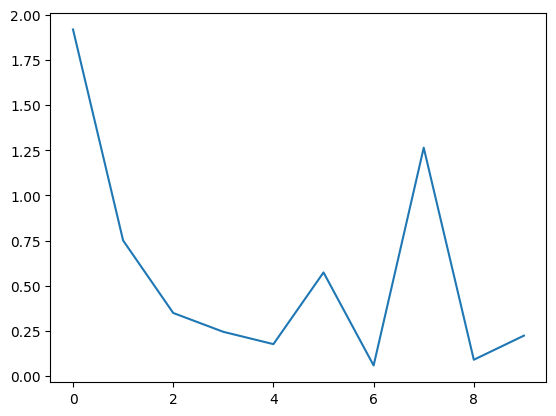

In [17]:
plt.plot(loss_arr)
plt.show()

In [18]:
# 맞은 개수, 전체 개수를 저장할 변수를 지정합니다.
correct = 0
total = 0

model.eval()

# 인퍼런스 모드를 위해 no_grad 해줍니다.
with torch.no_grad():
    # 테스트로더에서 이미지와 정답을 불러옵니다.
    for image,label in test_loader:

        # 두 데이터 모두 장치에 올립니다.
        x = image.to(device)
        y= label.to(device)

        # 모델에 데이터를 넣고 결과값을 얻습니다.
        output = model.forward(x)
        _,output_index = torch.max(output,1)


        # 전체 개수 += 라벨의 개수
        total += label.size(0)
        correct += (output_index == y).sum().float()

    # 정확도 도출
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 76.08999633789062%


In [56]:
print(f"Using device: {device}")
print(f"Device type set in summary: {'cpu' if device == torch.device('mps') else device.type}")


Using device: mps:0
Device type set in summary: mps


In [ ]:
print(model)